### Sina@DataKind.org

# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010 # Boroct2010 is the census tract number?...

### Coordinate systems, projections, and transformations 

In [5]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

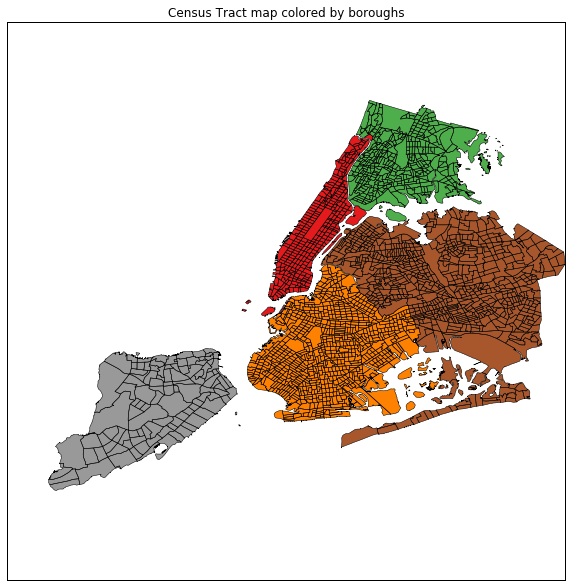

In [6]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax) # ax is the ax in the first line
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [7]:
#use Social Explorer to download some census tract data...
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str) # make the index string

#### Add popuation density to CT shapefile

In [8]:
#join my population density to the shapefile...
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


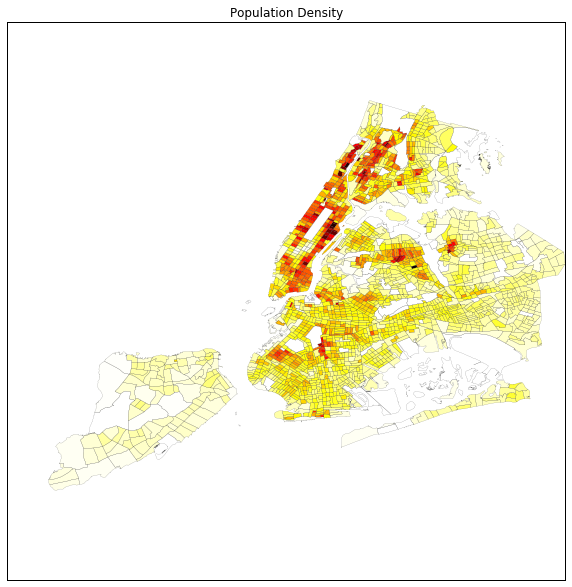

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [10]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

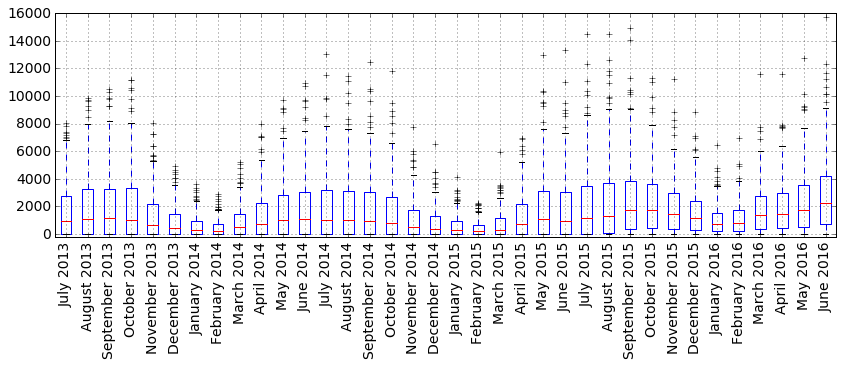

In [11]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


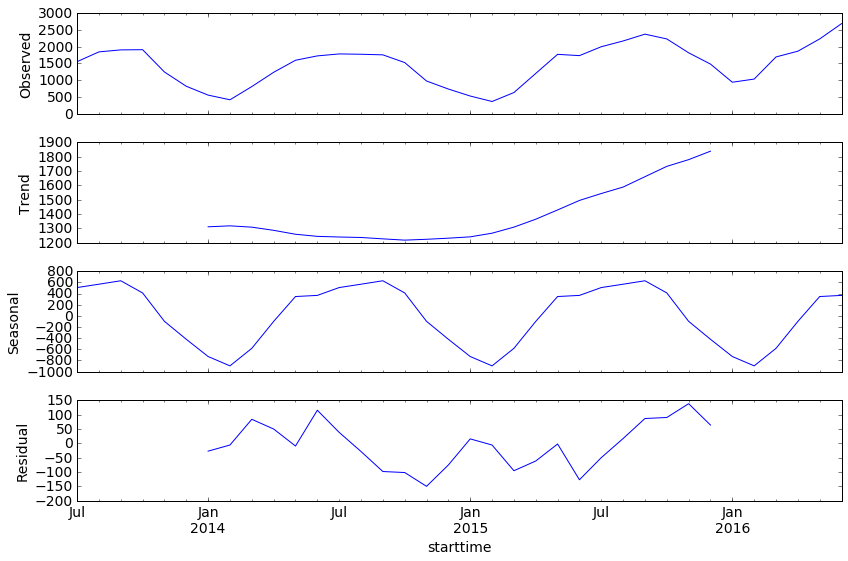

In [12]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna()) # the algorithm will break it for you, it's awesome...
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [13]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [14]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [15]:
#ct_shape's geometry is a shape...
ct_shape.head(3)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...


In [16]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4], # /r remove the print...
station_id['BoroCT2010']=a

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [20]:
citi_bymonth = df_bike_monthly.groupby(df_bike_monthly.index.month).sum()
citi_bymonth

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
1,2820,3006,10897,4346,6216,4502,1575,5396,2448,2235,...,0,0,0,0,0,0,0,0,0,0
2,2412,2911,9963,3677,5674,4297,1723,4882,1854,2059,...,0,0,0,0,0,0,0,0,0,0
3,3707,4740,16397,5371,9430,7216,3099,7886,3610,3543,...,0,0,0,0,0,0,0,0,0,0
4,5194,8405,21667,8217,14557,9925,4619,11998,5618,5083,...,310,0,0,0,0,0,0,0,0,0
5,6488,13275,28581,11073,19018,13067,6213,14416,7692,6787,...,901,62,20,2859,394,0,0,0,0,0
6,7756,10676,29213,11507,20534,13480,6155,14929,6389,7592,...,1036,0,0,7009,1109,665,2470,178,852,615
7,7151,10961,27145,10217,18352,10850,6563,12559,12510,7379,...,0,0,0,0,0,0,0,0,0,0
8,7515,11232,31017,11294,21004,11496,7444,13806,12865,7916,...,0,0,0,0,0,0,0,0,0,0
9,8274,13097,31462,11776,22859,13194,7612,14179,13183,8193,...,0,0,0,0,0,0,0,0,0,0
10,8189,11379,30326,10249,21877,13743,6438,13086,10881,7294,...,0,0,0,0,0,0,0,0,0,0


In [21]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['Monthlyave_summer'] = citi_bymonth[5:8].sum()
station_id['MonthlyAve_winter'] = citi_bymonth.ix[[1,2,12],:].sum()

In [22]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,Monthlyave_summer,MonthlyAve_winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,59890,21889


### Add the monthly average rides to the CT shapefile 

In [64]:
# use the 
temp=station_id[['Monthlyave_summer','MonthlyAve_winter']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Removing the CTs that are out of zoom boundries

In [65]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [66]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs for summer:", len(temp.Monthlyave_summer)
print "Number of zoomed CTs for winter:", len(temp.MonthlyAve_winter)

Total number of CTs: 2166
Number of zoomed CTs for summer: 543
Number of zoomed CTs for winter: 543


### Map the monthly rides 

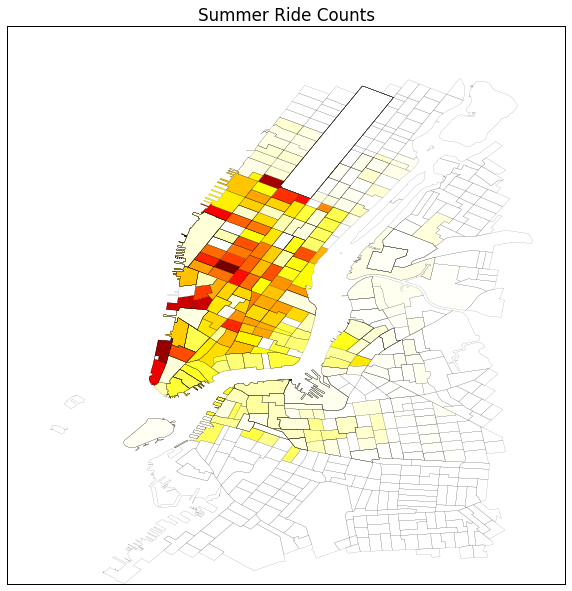

In [67]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='Monthlyave_summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

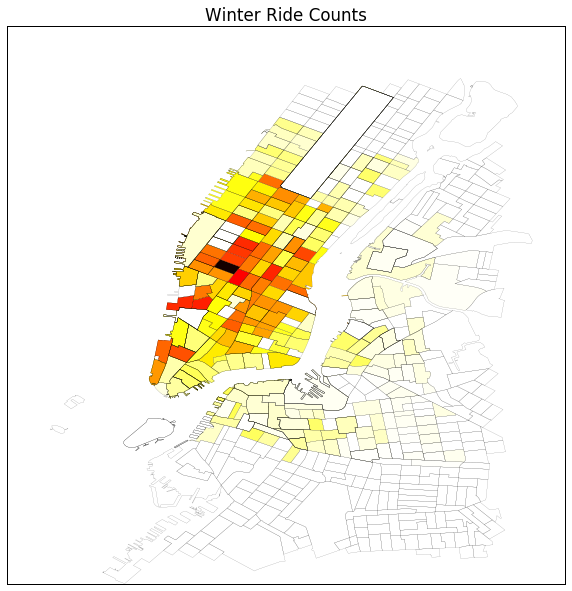

In [68]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve_winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [69]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)


## Exploratory Geospatial Analysis

In [37]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [57]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [58]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [59]:
qW_CT.cardinalities[10] # see how many friends he has...

9

#### Matrix of Weights

In [60]:
Wmatrix, ids = qW_CT.full()

In [61]:
Wmatrix # diagnal is zore, you are not a friend of yourself...

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [62]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [76]:
ct_shape_MonthlyAve_Zoom

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Monthlyave_summer,MonthlyAve_winter,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,14426.0,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,12061.0,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16893.0,10509.0,1329
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268031 40.6844914725429...,1214.0,0.0,1365
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268031 40.6844914725429...,2139.0,0.0,1367
1000500,1000500,1,Manhattan,I,000500,5,MN99,park-cemetery-etc-Manhattan,3810,9.081808e+06,32407.899284,(POLYGON ((-74.01092841268031 40.6844914725429...,1109.0,0.0,1537
1000600,1000600,1,Manhattan,E,000600,6,MN28,Lower East Side,3809,2.583418e+06,6970.634587,POLYGON ((-73.99022012603876 40.71440493989794...,32316.0,13560.0,1140


In [77]:
#MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
#MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

MonthlyRide_summer = ct_shape_MonthlyAve_Zoom.Monthlyave_summer
MonthlyRide_winter = ct_shape_MonthlyAve_Zoom.MonthlyAve_winter

MonthlyRideLag_summer = ps.lag_spatial(qW_CT, MonthlyRide_summer)
MonthlyRideLag_winter = ps.lag_spatial(qW_CT, MonthlyRide_winter)

#### Create Quantiles for maping

In [78]:
MonthlyRideLagQ10_s = ps.Quantiles(MonthlyRideLag_summer, k=10) # 10 quantiles...
MonthlyRideLagQ10_s

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [79]:
MonthlyRideLagQ10_w = ps.Quantiles(MonthlyRideLag_winter, k=10) # 10 quantiles...
MonthlyRideLagQ10_w

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the monthly rides lag

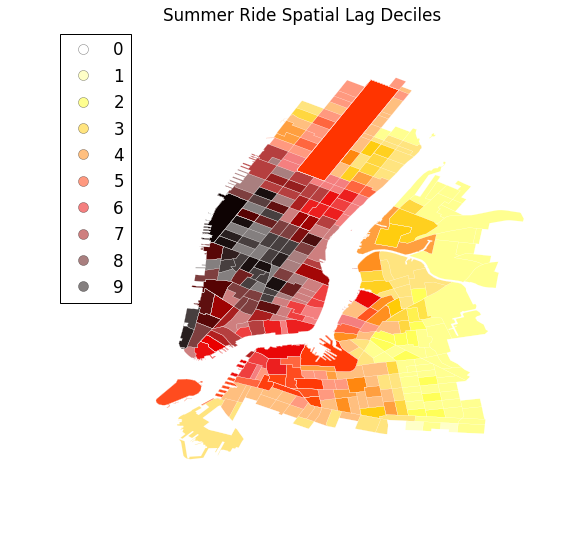

In [80]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10_s.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")


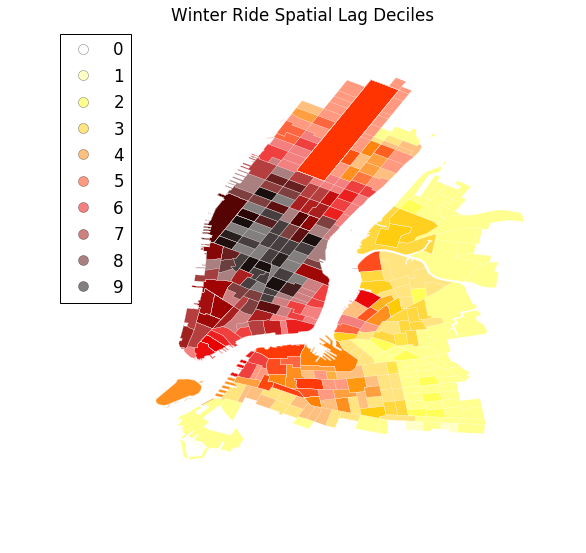

In [81]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10_w.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [82]:
b_s, a_s = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b_s, a_s

(0.64335490815356511, 4220.5552980795601)

In [83]:
b_w, a_w = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b_w, a_w

(0.66023249858156818, 1600.8324238675889)

### Moran Scatterplot

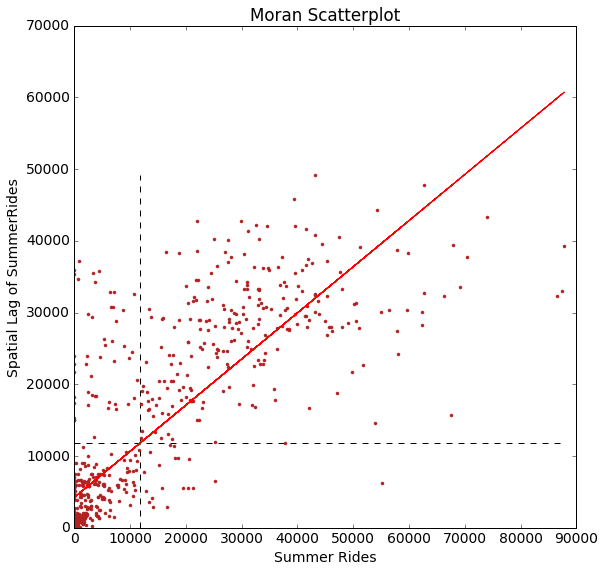

In [85]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a_s + b_s*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('Summer Rides')

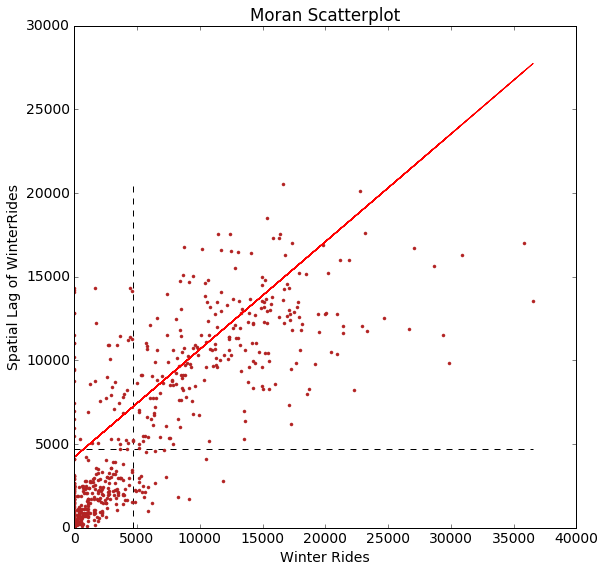

In [86]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a_s + b_s*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('Winter Rides')

### Moran's I

In [87]:
I_MonthlyRide_s = ps.Moran(MonthlyRide_summer, qW_CT)
I_MonthlyRide_w = ps.Moran(MonthlyRide_winter, qW_CT)

In [88]:
I_MonthlyRide_s.I, I_MonthlyRide_s.p_sim

(0.64353398667011008, 0.001)

In [89]:
I_MonthlyRide_w.I, I_MonthlyRide_w.p_sim

(0.66039156431885593, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [90]:
I_MonthlyRide_s.sim[0:10]

array([-0.01607977, -0.01604555,  0.01788428,  0.020551  ,  0.00627507,
       -0.0044892 , -0.01532937, -0.00547835, -0.01392183, -0.00235282])

In [91]:
I_MonthlyRide_w.sim[0:10]

array([-0.00454774,  0.01394417, -0.00355879, -0.00534651,  0.00512879,
        0.01647332,  0.00454852,  0.01037083, -0.00897788,  0.00022645])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [92]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

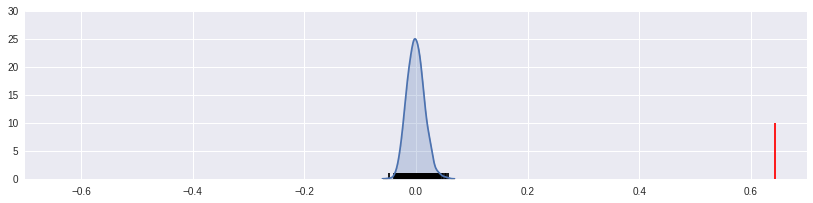

In [93]:
sns.kdeplot(I_MonthlyRide_s.sim, shade=True)
plt.vlines(I_MonthlyRide_s.sim, 0, 1)
plt.vlines(I_MonthlyRide_s.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

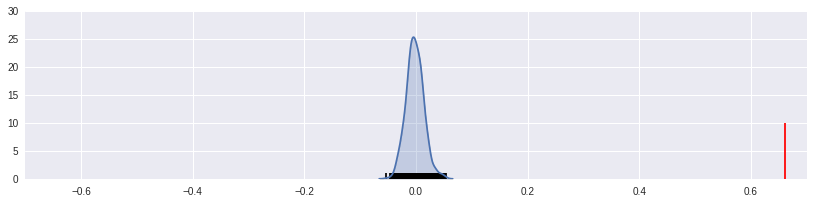

In [94]:
sns.kdeplot(I_MonthlyRide_w.sim, shade=True)
plt.vlines(I_MonthlyRide_w.sim, 0, 1)
plt.vlines(I_MonthlyRide_w.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

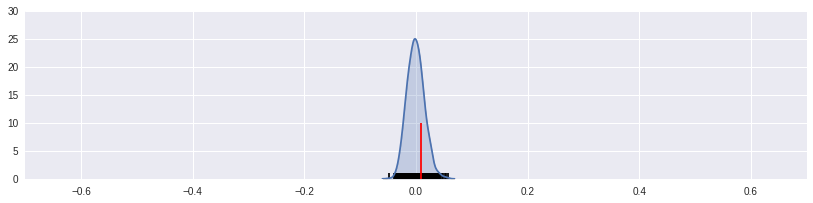

In [95]:
sns.kdeplot(I_MonthlyRide_s.sim, shade=True)
plt.vlines(I_MonthlyRide_s.sim, 0, 1)
plt.vlines(I_MonthlyRide_s.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

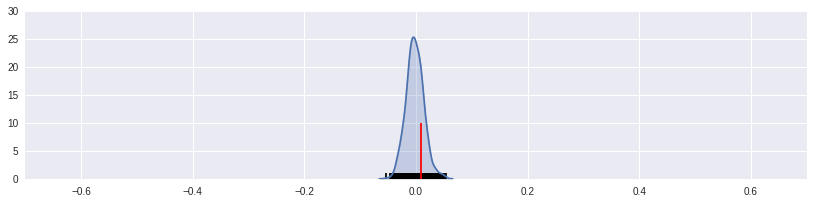

In [96]:
sns.kdeplot(I_MonthlyRide_w.sim, shade=True)
plt.vlines(I_MonthlyRide_w.sim, 0, 1)
plt.vlines(I_MonthlyRide_w.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [97]:
LMo_MonthlyRide_s = ps.Moran_Local(MonthlyRide_summer, qW_CT,permutations=999)
LMo_MonthlyRide_w = ps.Moran_Local(MonthlyRide_winter, qW_CT,permutations=999)

In [43]:
LMo_MonthlyRide_s.Is[0:5], LMo_MonthlyRide_s.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.186,  0.403,  0.416,  0.453]))

In [98]:
LMo_MonthlyRide_w.Is[0:5], LMo_MonthlyRide_w.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.135,  0.494,  0.482,  0.403]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [100]:
sigs_s = MonthlyRide_summer[LMo_MonthlyRide_s.p_sim <= .001]
W_sigs_s = MonthlyRideLag_summer[LMo_MonthlyRide_s.p_sim <= .001]
insigs_s = MonthlyRide_summer[LMo_MonthlyRide_s.p_sim > .001]
W_insigs_s = MonthlyRideLag_summer[LMo_MonthlyRide_s.p_sim > .001]

In [101]:
sigs_w = MonthlyRide_winter[LMo_MonthlyRide_w.p_sim <= .001]
W_sigs_w = MonthlyRideLag_winter[LMo_MonthlyRide_w.p_sim <= .001]
insigs_w = MonthlyRide_winter[LMo_MonthlyRide_w.p_sim > .001]
W_insigs_w = MonthlyRideLag_winter[LMo_MonthlyRide_w.p_sim > .001]

### Plot Signficant LISA

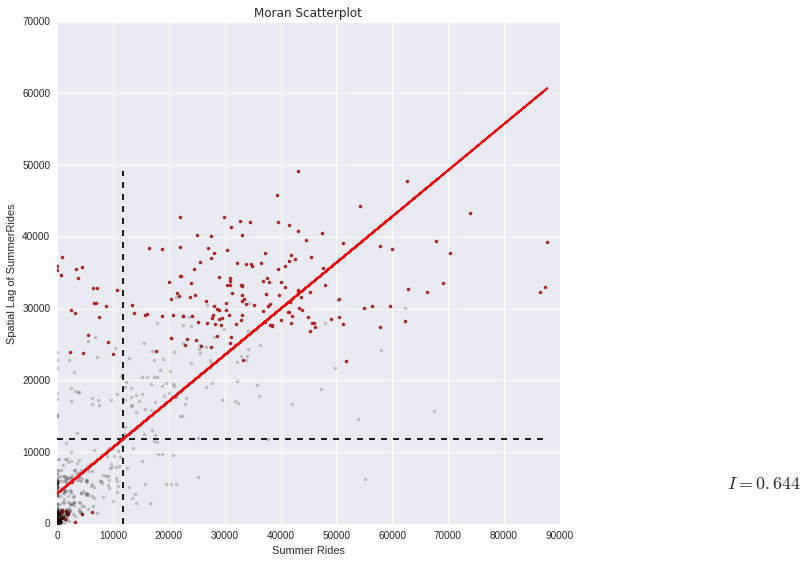

In [107]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_s, W_sigs_s, '.', color='firebrick')
plt.plot(insigs_s, W_insigs_s, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_s.I, x=120000, y=5000, fontsize=18)

plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')

plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a_s + b_s*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('Summer Rides')


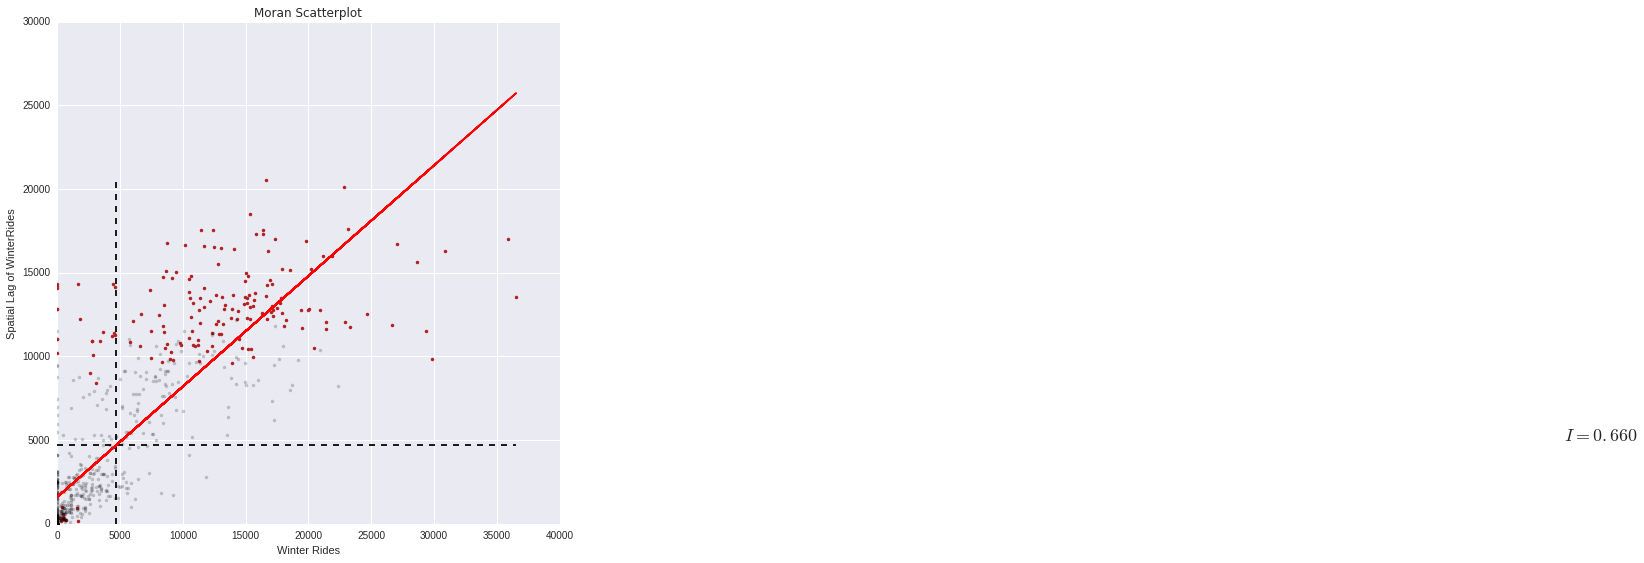

In [108]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_w, W_sigs_w, '.', color='firebrick')
plt.plot(insigs_w, W_insigs_w, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_w.I, x=120000, y=5000, fontsize=18)

plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')

plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a_w + b_w*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('Winter Rides')


### Hot and Cold spots 

In [110]:
sig_s = LMo_MonthlyRide_s.p_sim < 0.01
hotspots_s = LMo_MonthlyRide_s.q==1 * sig_s
coldspots_s = LMo_MonthlyRide_s.q==3 * sig_s
print "Number of Summer Hotspots:", hotspots_s.sum()
print "Number of Summer Coldspots:", coldspots_s.sum()

Number of Summer Hotspots: 188
Number of Summer Coldspots: 241


In [111]:
sig_w = LMo_MonthlyRide_w.p_sim < 0.01
hotspots_w = LMo_MonthlyRide_w.q==1 * sig_w
coldspots_w = LMo_MonthlyRide_w.q==3 * sig_w
print "Number of Winter Hotspots:", hotspots_s.sum()
print "Number of winter Coldspots:", coldspots_s.sum()

Number of Winter Hotspots: 188
Number of winter Coldspots: 241


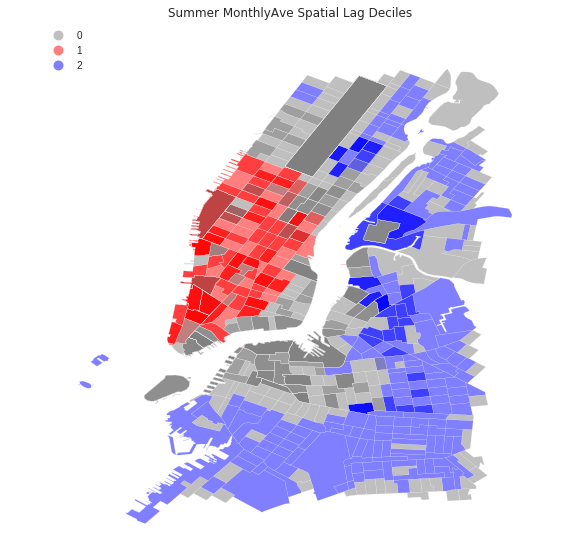

In [112]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_s = hotspots_s*1 + coldspots_s*2  # boolean, 0(no spots), 1(cold spots), 2(hot spots)...

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_s).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer MonthlyAve Spatial Lag Deciles")

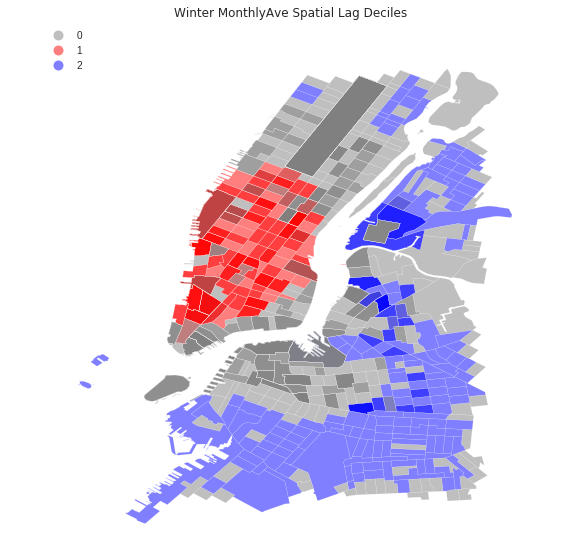

In [114]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w*1 + coldspots_w*2  # boolean, 0(no spots), 1(cold spots), 2(hot spots)...

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold_w).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter MonthlyAve Spatial Lag Deciles")

In [ ]:
# how you do threshold in your local...
# homwwork: winter is midtown downtown part , summer is central park part...